In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the URL to scrape
links = ["https://www.booking.com/reviews/country/ph.html","https://www.booking.com/reviews/country/ae.html",
         "https://www.booking.com/reviews/country/au.html","https://www.booking.com/reviews/country/br.html",
         "https://www.booking.com/reviews/country/ca.html","https://www.booking.com/reviews/country/de.html"]
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36",
}


In [2]:
# Function to fetch the HTML content of a page
def fetch_page(url):
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [3]:
def parse_reviews(html):
    soup = BeautifulSoup(html, "html.parser")
    reviews = []

    # Find the review blocks
    review_blocks = soup.find_all("div", class_="rlp-main-section-hotel__container")

    for block in review_blocks:
        try:
            # Extract review text
            review_text = block.find("p", class_="rlp-main-section-hotel-review__txt").get_text(strip=True)
            # Extract hotel name
            hotel_name = block.find("a", class_="rlp-main-section-hotel__name").get_text(strip=True)
            # Extract rating
            rating_text = block.find("span", class_="rlp-main-section-hotel__score-txt").get_text(strip=True)
            rating = rating_text.split()[-1]
            reviews.append({
                "hotel_name": hotel_name,
                "review": review_text,
                "rating": rating,
            })
        except AttributeError:
            # Skip if any required field is missing
            continue

    return reviews

In [4]:
# Main scraping function
def scrape_reviews(links, output_file):
    print("Starting scraping...")

    all_reviews = []

    for base_url in links:
        page_url = base_url

        while page_url:
            print(f"Fetching page: {page_url}")
            html = fetch_page(page_url)
            if not html:
                break

            reviews = parse_reviews(html)
            all_reviews.extend(reviews)

            soup = BeautifulSoup(html, "html.parser")
            next_page = soup.find("a", class_="bui-pagination__link", string="Next")
            page_url = BASE_URL + next_page["href"] if next_page else None
            time.sleep(3)  # Respectful delay between requests

    # Save reviews to CSV
    print(f"Saving {len(all_reviews)} reviews to {output_file}")
    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["hotel_name", "review", "rating"], quoting=csv.QUOTE_ALL)
        writer.writeheader()
        writer.writerows(all_reviews)

    print("Scraping completed.")

In [5]:
if __name__ == "__main__": 
    scrape_reviews(links, "hotel_reviews.csv")

Starting scraping...
Fetching page: https://www.booking.com/reviews/country/ph.html
Fetching page: https://www.booking.com/reviews/country/ae.html
Fetching page: https://www.booking.com/reviews/country/au.html


KeyboardInterrupt: 

In [5]:
import pandas as pd
df = pd.read_csv("new hotel.csv")
df.head(10)

,hotel_name,review,rating
0,Mariner's Pension House,"pool, all room have pool view, hammock, locati...",8.2
1,Floral Villarosa,"The property features attractive landscaping, ...",8.5
2,Rosanna's Pension,"Wow, the views were amazing! The location was...",8.3
3,R&D Traveller's Inn,"Very nice estate, nice room, a lot of space.\n...",8.9
4,Manta Dream Dive Resort,"Very nice estate, quite place, nice pool.\nThe...",8.5
5,Aurora Suites,"The room was quite clean, bed was comfortable....",7.2
6,The GoodVibes Condotel at28th Red Residences M...,"Loved how clean, cozy, nice everything was and...",9.7
7,Soffta Surf Ranch,"The fireplace, the rooms and jungle setting",8.4
8,Manila Lotus Hotel,Good value hotel in convenient location.,7.6
9,Junction Stays - City Center Apartments,Clean and accessible,8.5


In [15]:
np.unique(df['rating'])

array([4.5       , 5.8       , 6.1       , 6.4       , 6.6       ,
       7.2       , 7.3       , 7.4       , 7.6       , 7.8       ,
       7.9       , 8.        , 8.1       , 8.12542373, 8.2       ,
       8.3       , 8.4       , 8.5       , 8.6       , 8.7       ,
       8.8       , 8.9       , 9.        , 9.1       , 9.2       ,
       9.3       , 9.4       , 9.7       , 9.8       ])

In [13]:
# Replace 'yet' with 0
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

mean_value = df['rating'].mean()
df['rating'].fillna(mean_value, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_18132\4055361973.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(mean_value, inplace=True)


In [14]:
np.unique(df['rating'])

array([4.5       , 5.8       , 6.1       , 6.4       , 6.6       ,
       7.2       , 7.3       , 7.4       , 7.6       , 7.8       ,
       7.9       , 8.        , 8.1       , 8.12542373, 8.2       ,
       8.3       , 8.4       , 8.5       , 8.6       , 8.7       ,
       8.8       , 8.9       , 9.        , 9.1       , 9.2       ,
       9.3       , 9.4       , 9.7       , 9.8       ])

In [16]:
df

,hotel_name,review,rating
0,Mariner's Pension House,"pool, all room have pool view, hammock, locati...",8.200000
1,Floral Villarosa,"The property features attractive landscaping, ...",8.500000
2,Rosanna's Pension,"Wow, the views were amazing! The location was...",8.300000
3,R&D Traveller's Inn,"Very nice estate, nice room, a lot of space.\n...",8.900000
4,Manta Dream Dive Resort,"Very nice estate, quite place, nice pool.\nThe...",8.500000
5,Aurora Suites,"The room was quite clean, bed was comfortable....",7.200000
6,The GoodVibes Condotel at28th Red Residences M...,"Loved how clean, cozy, nice everything was and...",9.700000
7,Soffta Surf Ranch,"The fireplace, the rooms and jungle setting",8.400000
8,Manila Lotus Hotel,Good value hotel in convenient location.,7.600000
9,Junction Stays - City Center Apartments,Clean and accessible,8.500000


In [28]:
# Preprocessing function for reviews
import spacy
import contractions
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    text = str(text)
    text = contractions.fix(text)
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_punct]
    tokens = {token.lower() for token in tokens if token.lower() not in ENGLISH_STOP_WORDS}
    tokens = [re.sub(r'[^a-zA-Z\s]', '', token) for token in tokens]
    return tokens

In [37]:
# Clean the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join(x))

In [42]:
# Combine all text from the 'cleaned_review' column into a single string
text = ' '.join(df['cleaned_review'].dropna())


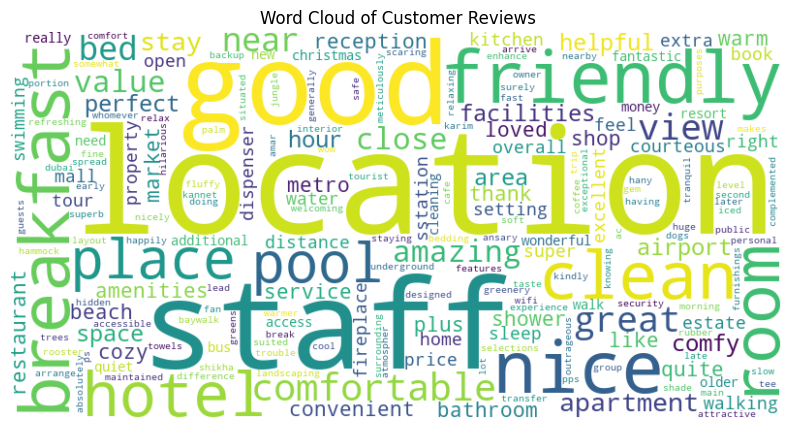

In [43]:
# Generate a Word Cloud
wordcloud = WordCloud(stopwords='english', width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Reviews')
plt.show()

### 2. Zero-Shot Classification 


In [44]:
from transformers import pipeline
import tensorflow as tf 
from tensorflow import keras
from tqdm import tqdm
tqdm.pandas()

In [45]:
classifier = pipeline("zero-shot-classification", device=0, model = "MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")

Device set to use cuda:0


In [46]:
labels= ['positive', 'negative', 'neutral']
zero_df = df.copy(deep=True)

# zero_df['classifier_dict'] = zero_df['comments'].progress_apply(lambda x: classifier(x, labels)['labels'][0])
zero_df['sentiment_dict'] = zero_df['cleaned_review'].progress_apply(lambda x: classifier(x, labels))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.49it/s]


In [47]:
zero_df['sentiment_label'] = zero_df['sentiment_dict'].apply(lambda x: x['labels'][0])
zero_df

,hotel_name,review,rating,cleaned_review,sentiment_dict,sentiment_label
0,Mariner's Pension House,"pool, all room have pool view, hammock, locati...",8.200000,airport cafe location places walking pool \n p...,{'sequence': 'airport cafe location places wal...,neutral
1,Floral Villarosa,"The property features attractive landscaping, ...",8.500000,reception refreshing friendly pool enhance sta...,{'sequence': 'reception refreshing friendly po...,positive
2,Rosanna's Pension,"Wow, the views were amazing! The location was...",8.300000,convenient location coffee views staff super p...,{'sequence': 'convenient location coffee views...,positive
3,R&D Traveller's Inn,"Very nice estate, nice room, a lot of space.\n...",8.900000,estate warm dogs nice bed friendly \n plus sur...,{'sequence': 'estate warm dogs nice bed friend...,positive
4,Manta Dream Dive Resort,"Very nice estate, quite place, nice pool.\nThe...",8.500000,estate warm nice bed friendly pool \n selectio...,{'sequence': 'estate warm nice bed friendly po...,positive
5,Aurora Suites,"The room was quite clean, bed was comfortable....",7.200000,clean room airport close location bed comforta...,{'sequence': 'clean room airport close locatio...,positive
6,The GoodVibes Condotel at28th Red Residences M...,"Loved how clean, cozy, nice everything was and...",9.700000,clean super situated hotel loved cozy nice gem,{'sequence': 'clean super situated hotel loved...,positive
7,Soffta Surf Ranch,"The fireplace, the rooms and jungle setting",8.400000,fireplace rooms jungle setting,"{'sequence': 'fireplace rooms jungle setting',...",neutral
8,Manila Lotus Hotel,Good value hotel in convenient location.,7.600000,good hotel convenient location value,{'sequence': 'good hotel convenient location v...,positive
9,Junction Stays - City Center Apartments,Clean and accessible,8.500000,clean accessible,"{'sequence': 'clean accessible', 'labels': ['n...",neutral


In [51]:
df.columns

Index(['hotel_name', 'review', 'rating', 'cleaned_review'], dtype='object')

### 3. Feature Engineering (TF-IDF)

In [54]:
# Define the mapping dictionary 
label_mapping = { 'neutral': 0, 'positive': 1, 'negative': -1} 
zero_df['sentiment_numeric'] = zero_df['sentiment_label'].map(label_mapping)

In [55]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(zero_df['cleaned_review']).toarray()
y = zero_df['sentiment_numeric']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4. Model Training and Evaluation

In [63]:
from sklearn.metrics import classification_report, accuracy_score

In [64]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) 
    print(f"Accuracy for {model_name}: {accuracy:.4f}")

Training Random Forest...
Accuracy for Random Forest: 0.6667
Training Decision Tree...
Accuracy for Decision Tree: 0.8333
Training Logistic Regression...
Accuracy for Logistic Regression: 0.6667
Training SVM...
Accuracy for SVM: 0.6667
Training XGBoost...
Accuracy for XGBoost: 0.6667


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
